# Year in Pixels Visualizations

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgba, Normalize
import seaborn as sns
import json
import datetime

In [2]:
# load externally defined environment variables
from dotenv import dotenv_values
env_vars = dotenv_values()

In [3]:
# load color palette from environment variables
palette_list = [env_vars["COLOR_PALETTE_{}".format(i)] for i in range(1,6)]
palette_list

['ff2700', '88220d', '151518', '213788', '00bfff']

In [4]:
# data extraction into Pandas DataFrame
year = env_vars['YEAR']

with open('./data/data_{}.json'.format(year)) as fp:
    data = json.load(fp)
data = pd.DataFrame(data)
data = data.drop(columns=['type'])
data

,date,scores,notes,tags
0,2022-4-1,[3],,"[{'type': 'Emotions', 'entries': ['excitement'..."
1,2022-4-2,[4],,"[{'type': 'Emotions', 'entries': ['bore', 'chi..."
2,2022-4-3,[1],,"[{'type': 'Emotions', 'entries': ['anger', 'an..."
3,2022-4-4,[3],,"[{'type': 'Emotions', 'entries': ['anxiety', '..."
4,2022-4-5,[2],,"[{'type': 'Emotions', 'entries': ['bore', 'chi..."
...,...,...,...,...
954,2024-11-10,[3],Worked quite a bit for a Sunday. Happy for a p...,"[{'type': 'Productivity Rating', 'entries': ['..."
955,2024-11-11,[3],Maurizio fell ill. Will have even more stuff t...,"[{'type': 'Productivity Rating', 'entries': ['..."
956,2024-11-12,[3],Shaved my head and shaped my beard in the morn...,"[{'type': 'Productivity Rating', 'entries': ['..."
957,2024-11-13,[4],"Back to Milan. Today's lecture was called off,...","[{'type': 'Productivity Rating', 'entries': ['..."


In [ ]:
# data cleaning
data['scores'] = data['scores'].apply(lambda x : int(x[0])) # convert scores from lists to integers
data['date'] = data['date'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d')) # convert dates from strings to datetime objects

# make a column for each tag
tags = {}
for index, row in data.iterrows():
    row_data = {}
    tags_list = row['tags']
    for tag in tags_list:
        if tag['type'] not in row_data:
            row_data = {**row_data, tag['type'] : tag['entries']}
        else:
            row_data[tag['type']].extend(tag['entries'])
    tags = {**tags, index : row_data}

tags = pd.DataFrame(tags).T

data = pd.concat([data, tags], axis=1).drop(columns=['tags'])

data['Productivity Rating'] = data['Productivity Rating'].apply(lambda x : int(x[0]) if isinstance(x, list) else 0) # convert productivity ratings from list to int

# Filter for this year's and last year's data
def check_year(year_to_check : datetime.date, reference : int):
    return True if year_to_check.year == reference else False

data_all = data

mask_previous_year = data_all['date'].apply(lambda x : check_year(x, int(year)-1))
data_previous_year = data_all[mask_previous_year]

mask_current_year = data_all['date'].apply(lambda x : check_year(x, int(year)))
data_current_year = data_all[mask_current_year]

# Pixels (Github-like viz)

In [6]:
# Pixels viz function (each row is one week, squares are a little spaced out and rounded, month labels are visible)
def generate_pixels_heatmap(df : pd.DataFrame, palette : list[str], output_file : str):
    """
    Generates a GitHub-style heatmap chart.

    Parameters:
        df (pd.DataFrame): DataFrame with 'date' (datetime) and 'scores' columns.
        palette (list): List of hexadecimal color strings defining the color palette.
        output_file (str): Path to save the resulting PNG image.

    Returns:
        None
    """
    # Ensure 'date' column is datetime
    df['date'] = pd.to_datetime(df['date'])

    # Create a full year of dates for the current year
    year = df['date'].dt.year.min()
    start_date = pd.Timestamp(f'{year}-01-01')
    end_date = pd.Timestamp(f'{year}-12-31')
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Create a DataFrame for all days of the year
    all_days = pd.DataFrame({'date': all_dates})

    # Merge with the input DataFrame to align data
    df = all_days.merge(df, on='date', how='left').fillna({'rating': 0})

    # Add week and day of the week for plotting
    df['week'] = df['date'].dt.isocalendar().week
    df['day_of_week'] = df['date'].dt.weekday

    # Handle the edge case where week 53 exists in the data
    if df['week'].max() == 53:
        df.loc[df['week'] == 53, 'week'] = 52

    # Ensure unique entries for pivot table by averaging ratings for duplicate days
    df = df.groupby(['week', 'day_of_week'], as_index=False)['scores'].mean()

    # Create a pivot table for heatmap data
    heatmap_data = df.pivot(index='day_of_week', columns='week', values='scores')

    # Convert hexadecimal palette to RGBA
    rgba_palette = [to_rgba('#'+color) for color in palette]

    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list("custom_palette", rgba_palette, N=256)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        linewidths=0.5,
        linecolor='black',
        cbar=False,
        square=True
    )

    # Style the plot to look like GitHub
    plt.gca().invert_yaxis()
    plt.axis('off')

    # Save the heatmap to a PNG file with a transparent background
    plt.savefig(output_file, dpi=600, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close()

In [7]:
# Execution (2024)
generate_pixels_heatmap(data_current_year.copy(), palette_list, 'pixels_grid.png')

# Average Rating YoY

In [8]:
# Avg rating viz function, YoY increments if existing

def plot_average_rating(data : pd.DataFrame, palette_list : list[str], output_file : str):
    """
    Plot a colorbar representing the ratings range and draw the average rating on it.

    Parameters:
        data (pd.DataFrame): DataFrame with 'scores' column.
        palette_list (list): List of hexadecimal color strings defining the color palette.
        output_file (str): Path to save the resulting PNG image.

    Returns:
        None.
    """
    # Define the ratings range
    ratings_range = (0, 5)

    # Calculate the average rating
    average_rating = data['scores'].mean()

    # Create a LinearSegmentedColormap from the palette
    rgba_palette = [to_rgba('#'+color) for color in palette_list]
    cmap = LinearSegmentedColormap.from_list("custom_palette", rgba_palette, N=256)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 1))

    range_x_axis = np.linspace(ratings_range[0], ratings_range[1], len(palette_list)*256)

    # Draw the colorbar
    norm = Normalize(vmin=ratings_range[0], vmax=ratings_range[1])
    thinness = 20
    aspect = 1/thinness
    cb = ax.imshow(range_x_axis.reshape((1,len(palette_list)*256)), cmap=cmap, aspect=aspect, norm=norm, extent=[ratings_range[0], ratings_range[1],0, thinness])
    ax.set_yticks([])
    ax.set_xticks([])

    # Draw the rating milestones
    # milestones = range_x_axis
    # for milestone in milestones:
    #     ax.scatter(milestone * 256 / ratings_range[1], 0.5, color=cmap(norm(milestone)), s=800, edgecolors='black', zorder=20)

    # Draw the average rating indicator
    ax.axvline(average_rating, color='white', linewidth=5, zorder=10)
    ax.text(ratings_range[0] - 0.1, 0.5, f'{average_rating:.2f}', color='white', ha='right', va='bottom', fontsize=48, fontweight='bold', fontname='Helvetica')
    fig.set_facecolor('black')

    plt.show()

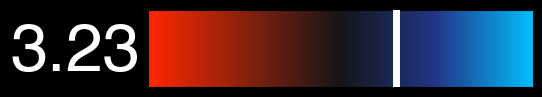

In [9]:
# Show the plot
plot_average_rating(data_current_year.copy(), palette_list, None)

In [10]:
# Line chart of avg rating per year
def plot_avg_ratings_per_year(data_all : pd.DataFrame, label : str, palette_list : list[str]):
    years = list(range(
        data_all.loc[0,['date']].to_numpy()[0].year,
        data_all.loc[data_all.shape[0]-1, ['date']].to_numpy()[0].year+1,
        1))

    avgs = []
    for year in years:
        filter = data_all['date'].apply(lambda x : check_year(x, year))
        data_filtered = data_all[filter]
        avgs.append(data_filtered[label].mean())

    fig, ax = plt.subplots(figsize=(5,4))

    for data_point in range(len(avgs)):
        ax.annotate(f'{avgs[data_point]:.2f}', (years[data_point]+0.1,avgs[data_point]), color='white', fontname='Helvetica', fontsize=15, fontweight='bold')
        ax.axvline(years[data_point], ymin=0.0, ymax=(avgs[data_point]-min(avgs))/(max(avgs)-min(avgs)) - 0.025, color='white', linestyle='--')

    ax.plot(years, avgs, 'o-', color='#'+palette_list[-1], linewidth=3.5, markersize=10)
    ax.set_yticks([])
    ax.set_xticks(years, labels=years, fontname='Helvetica', fontweight='bold', fontsize=17, color='white')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    plt.show()

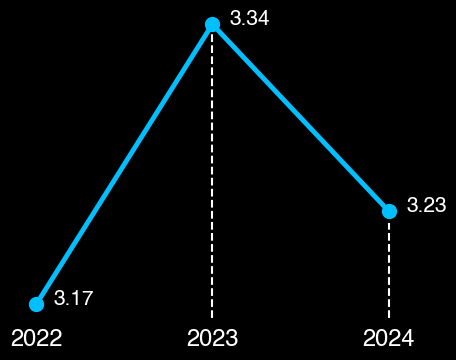

In [41]:
# Execution (2024)
plot_avg_ratings_per_year(data_all.copy(), 'scores', palette_list)

# Rating Frequency

In [12]:
# Rating frequency pie chart (with YoY increments if existing) viz function

In [13]:
# Execution (2024)

# Avg Rating per Weekday

In [14]:
# (Normalized) Avg rating/productivity level per weekday/tag viz function, with YoY increments if existing

In [15]:
# Execution (2024, rating)

# Emotion Frequency

In [16]:
# Tag frequency viz function (descending sort by frequency)

In [17]:
# Execution (2024, emotions)

# Activity Frequency

In [18]:
# Execution (2024, activities)

# Activity-Emotion Correlation

In [19]:
# Pairwise tag-tag correlation (Pearson) heatmap function

In [20]:
# Execution (2024, activity v. emotion)

# Location-Emotion Correlation

In [21]:
# Execution (2024, location v. emotion)

# Sick Days 🤒

In [22]:
# Number of symptoms + number of pharmaceuticals calendar viz function, ratings in semi-transparency, skull 💀 emoji if bad day + sick day

In [23]:
# Total number of sick (💀) days per year line chart

In [24]:
# Execution (2024)

# Productivity

In [25]:
# Productivity calendar viz function, ratings in semi-transparency

In [26]:
# Average productivity per year line chart

In [27]:
# Avg productivity per weekday execution (2024)

In [28]:
# Execution (2024)

# Weighted Avg Rating per Tag

In [29]:
# (Normalized) Avg rating per productivity level execution (2024)

In [30]:
# (Normalized) Avg rating per location execution (2024)

In [31]:
# (Normalized) Avg rating per emotion execution (2024)

In [32]:
# (Normalized) Avg rating per activity execution (2024)

In [33]:
# (Normalized) Avg rating per medication execution (2024)

In [34]:
# (Normalized) Avg rating per symptom execution (2024)

# Locations Visited 🛫

In [35]:
# 3D Map with visit frequency and average rating per location viz function

In [36]:
# Execution (2024)

# Word Clouds ☁️

In [37]:
# Word cloud per daily notes (filtered by rating) viz function

In [38]:
# Execution (2024, all days)

In [39]:
# Execution (2024, bad days: rating 1,2)

In [40]:
# Execution (2024, good days: rating 4,5)